任务：根据original_data样本，建立模型，对test_data的图片进行普通/其他苹果判断:
1.数据增强，扩充确认为普通苹果的样本数量
2.特征提取，使用VGG16模型提取图像特征
3.图片批量处理
4.Kmeans模型尝试普通、其他苹果聚类
5.基于标签数据矫正结果，并可视化
6.Meanshift模型提升模型表现
7.数据降维PCA处理，提升模型表现

注意：数据会决定你模型表现的上限


In [1]:
#数据增强 
from keras.preprocessing.image import ImageDataGenerator
path = "./dataset/original_data"
dst_path = "./dataset/gen_data"

datagen = ImageDataGenerator(rotation_range=10, # 旋转范围
                             width_shift_range=0.1, # 水平平移范围
                             height_shift_range=0.02, # 垂直平移范围
                             horizontal_flip=True, # 水平翻转
                             vertical_flip=True) # 垂直翻转
gen = datagen.flow_from_directory(path,
                                  target_size=(224,224), # 所有图象调整为统一尺寸，vgg16的输入大小是224*224
                                  batch_size=2, # 一次生成两张
                                  save_to_dir=dst_path, # 保存路径
                                  save_prefix="gen_", # 保存圖片文件名前綴
                                  save_format="jpg") # 默认png
#一次生成2张，理论上是生成batch_size*循环次数也就是200张，但是实际只生成180不知道为什么
#然后batch_size >文件夹中图片数量也只会按文件夹中图片数量最大来生成
for i in range(100):
    gen.next()

Found 10 images belonging to 1 classes.


**单张图片展示 特征提取**

In [2]:
# load the image
# from keras.preprocessing import load_img,img_to_array # keras2.6后取消
from keras.preprocessing.image import load_img,img_to_array

img_path = r"./dataset/train_data/1.jpg"
img = load_img(img_path,target_size=(224,224))
print(type(img))

<class 'PIL.Image.Image'>


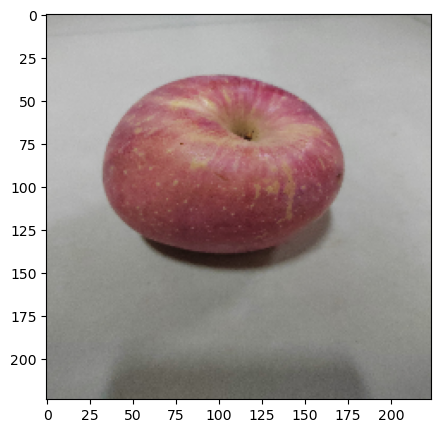

In [3]:
# visualize the image
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(5,5))
plt.imshow(img)

In [4]:
img = img_to_array(img)
type(img)

numpy.ndarray

In [6]:
# 加载模型
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
model_vgg = VGG16(weights="imagenet",include_top=False)
X = np.expand_dims(img,axis=0) # 增加一个维度
X = preprocess_input(X)
print(X.shape)

(1, 224, 224, 3)


In [7]:
# 特征提取
features = model_vgg.predict(X)
print(features.shape)

1/1 [==============================] - 0s 206ms/step
(1, 7, 7, 512)


In [8]:
# flatten
features = features.reshape(1,7*7*512)
print(features.shape)

(1, 25088)


**批量提取**

In [35]:
# list all the names of the data
import os 
folder = r"./dataset/train_data"
dirs = os.listdir(folder)
# print(dirs)
# 名称合并
img_path = []
for i in dirs:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(f'{folder}/{i}')
print(img_path[0])

./dataset/train_data/1.jpg


In [37]:
# define a method to extract the features
def modelProcess(img_path, model):
    img = load_img(img_path,target_size=(224,224))
    img = img_to_array(img)
    x = np.expand_dims(img,axis=0)
    x = preprocess_input(x)
    x_vgg = model.predict(x)
    x_vgg = x_vgg.reshape(1,25088)
    return x_vgg

In [38]:
# 图像批量处理
features_train = np.zeros([len(img_path),7*7*512])
for i in range(len(img_path)):
    features_i = modelProcess(img_path[i],model_vgg)
    print("preprocessed:",img_path[i])
    features_train[i] = features_i

1/1 [==============================] - 0s 95ms/step
preprocessed: ./dataset/train_data/1.jpg
1/1 [==============================] - 0s 88ms/step
preprocessed: ./dataset/train_data/10.jpg
1/1 [==============================] - 0s 96ms/step
preprocessed: ./dataset/train_data/2.jpg
1/1 [==============================] - 0s 94ms/step
preprocessed: ./dataset/train_data/3.jpg
1/1 [==============================] - 0s 88ms/step
preprocessed: ./dataset/train_data/4.jpg
1/1 [==============================] - 0s 90ms/step
preprocessed: ./dataset/train_data/5.jpg
1/1 [==============================] - 0s 88ms/step
preprocessed: ./dataset/train_data/6.jpg
1/1 [==============================] - 0s 104ms/step
preprocessed: ./dataset/train_data/7.jpg
1/1 [==============================] - 0s 88ms/step
preprocessed: ./dataset/train_data/8.jpg
1/1 [==============================] - 0s 93ms/step
preprocessed: ./dataset/train_data/9.jpg
1/1 [==============================] - 0s 96ms/step
preprocessed: ./

In [39]:
print(features_train.shape)

(230, 25088)


In [42]:
#define X; 30>>10普通苹果》》+200普通苹果
X = features_train

[0.         0.         0.         ... 0.         3.97909236 0.        ]


In [43]:
# set up a kmeans un-supervised model
from sklearn.cluster import KMeans
cnn_kmeans = KMeans(n_clusters=2,max_iter=2000)
cnn_kmeans.fit(X)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(max_iter=2000, n_clusters=2)

In [44]:
# make prediction
y_predict_kmeans = cnn_kmeans.predict(X)
print(y_predict_kmeans)

[1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0
 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0]


In [45]:
#统计
from collections import Counter
print(Counter(y_predict_kmeans))

Counter({0: 166, 1: 64})


In [51]:
#假设普通苹果id为0
normal_apple_id = 0

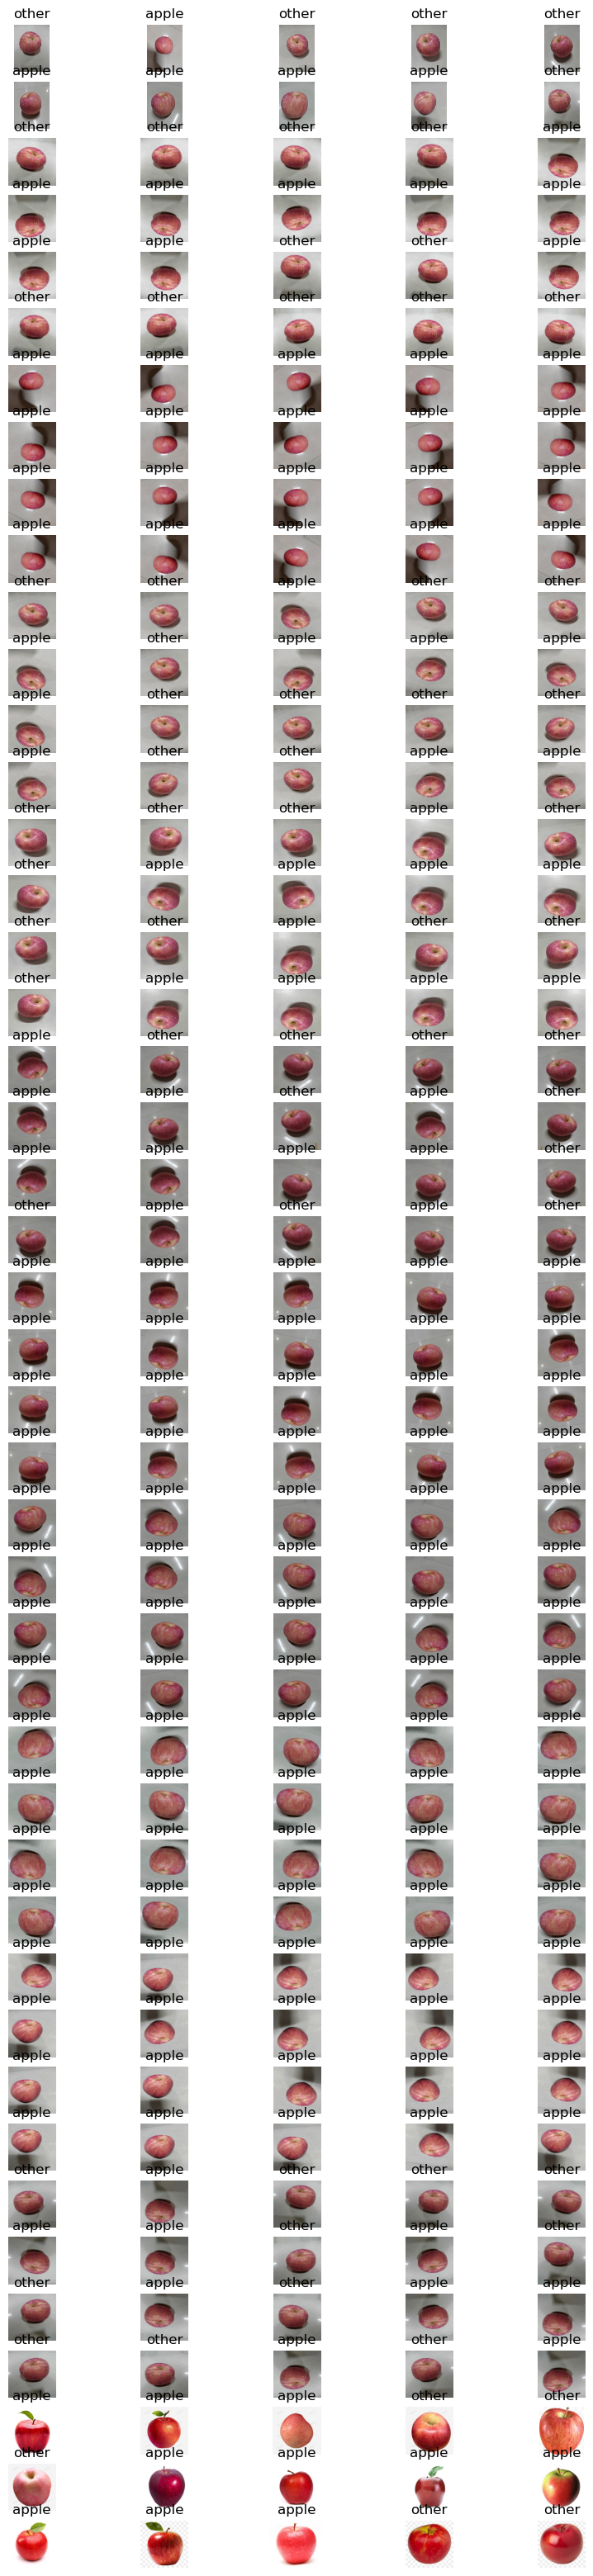

In [54]:
# visualize the resilt
fig2 = plt.figure(figsize=(10,40))
for i in range(45):
    for j in range(5):
        img = load_img(img_path[i*5+j]) # read the image
        plt.subplot(45,5,i*5+j+1)
        plt.title("apple" if y_predict_kmeans[i*5+j] == normal_apple_id else "other")
        plt.imshow(img)
        plt.axis("off")

In [55]:
# list all the names of the data
import os 
folder_test = r"./dataset/test_data"
dirs_test = os.listdir(folder_test)
# print(dirs_test)
img_path_test = []
for i in dirs_test:
    if os.path.splitext(i)[1] == ".jpg":
        img_path_test.append(f'{folder_test}/{i}')
print(img_path_test[0])
print(len(img_path_test))

./dataset/test_data/1.jpg
12


In [56]:
#数据处理
features_test = np.zeros([len(img_path_test),7*7*512])
for i in range(len(img_path_test)):
    features_i = modelProcess(img_path_test[i],model_vgg)
    print("preprocessed:",img_path_test[i])
    features_test[i] = features_i

1/1 [==============================] - 0s 93ms/step
preprocessed: ./dataset/test_data/1.jpg
1/1 [==============================] - 0s 90ms/step
preprocessed: ./dataset/test_data/2.jpg
1/1 [==============================] - 0s 94ms/step
preprocessed: ./dataset/test_data/3.jpg
1/1 [==============================] - 0s 102ms/step
preprocessed: ./dataset/test_data/4.jpg
1/1 [==============================] - 0s 90ms/step
preprocessed: ./dataset/test_data/5.jpg
1/1 [==============================] - 0s 91ms/step
preprocessed: ./dataset/test_data/6.jpg
1/1 [==============================] - 0s 94ms/step
preprocessed: ./dataset/test_data/others_1.jpg
1/1 [==============================] - 0s 100ms/step
preprocessed: ./dataset/test_data/others_14.jpg
1/1 [==============================] - 0s 118ms/step
preprocessed: ./dataset/test_data/others_15.jpg
1/1 [==============================] - 0s 97ms/step
preprocessed: ./dataset/test_data/others_18.jpg
1/1 [==============================] - 0s 91ms

In [57]:
X_test = features_test
print(X_test.shape)

(12, 25088)


In [58]:
#预测
y_predict_kmeans_test = cnn_kmeans.predict(X_test)
print(y_predict_kmeans_test)

[1 1 1 1 0 0 0 1 0 0 1 0]


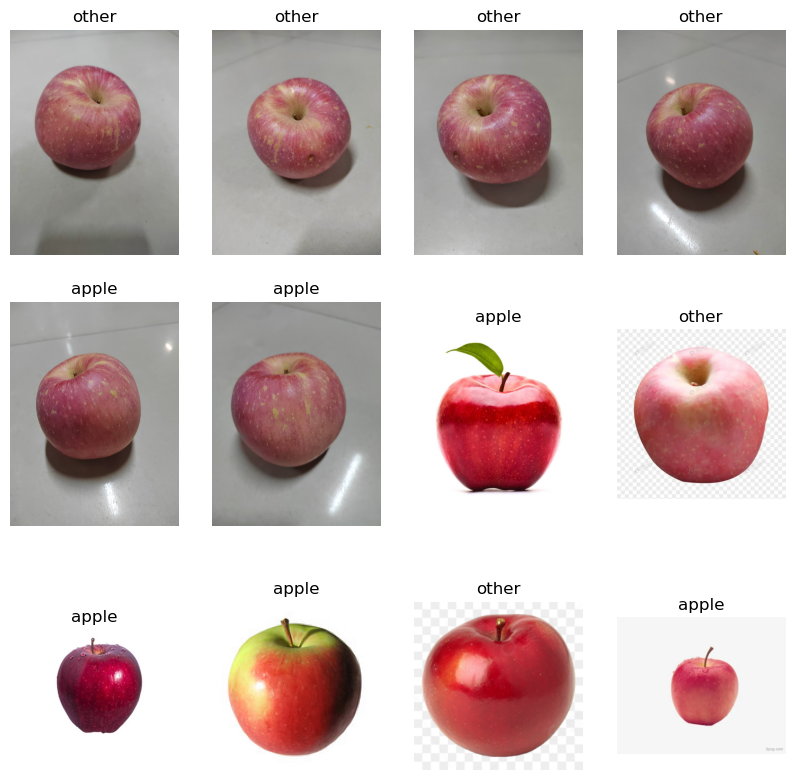

In [60]:
# visualize the resilt
fig3 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(img_path_test[i*4+j])
        plt.subplot(3,4,i*4+j+1)
        plt.title("apple" if y_predict_kmeans_test[i*4+j] == normal_apple_id else "other")
        plt.imshow(img)
        plt.axis("off")

In [61]:
# meanShift
from sklearn.cluster import MeanShift,estimate_bandwidth
# obtain the bandwidth
bw = estimate_bandwidth(X,n_samples = 140)
print(bw)
# set up meanshift model
cnn_ms = MeanShift(bandwidth = bw)
cnn_ms.fit(X)

1002.8668772723131


MeanShift(bandwidth=1002.8668772723131)

In [62]:
# make prediction
y_predict_ms = cnn_ms.predict(X)
print(y_predict_ms)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  7  8  6 10  9
 16 14 17 19 15 11 18  5  4  3  1  2 13  0]


In [63]:
#统计预测结果
print(Counter(y_predict_ms))

Counter({0: 211, 12: 1, 7: 1, 8: 1, 6: 1, 10: 1, 9: 1, 16: 1, 14: 1, 17: 1, 19: 1, 15: 1, 11: 1, 18: 1, 5: 1, 4: 1, 3: 1, 1: 1, 2: 1, 13: 1})


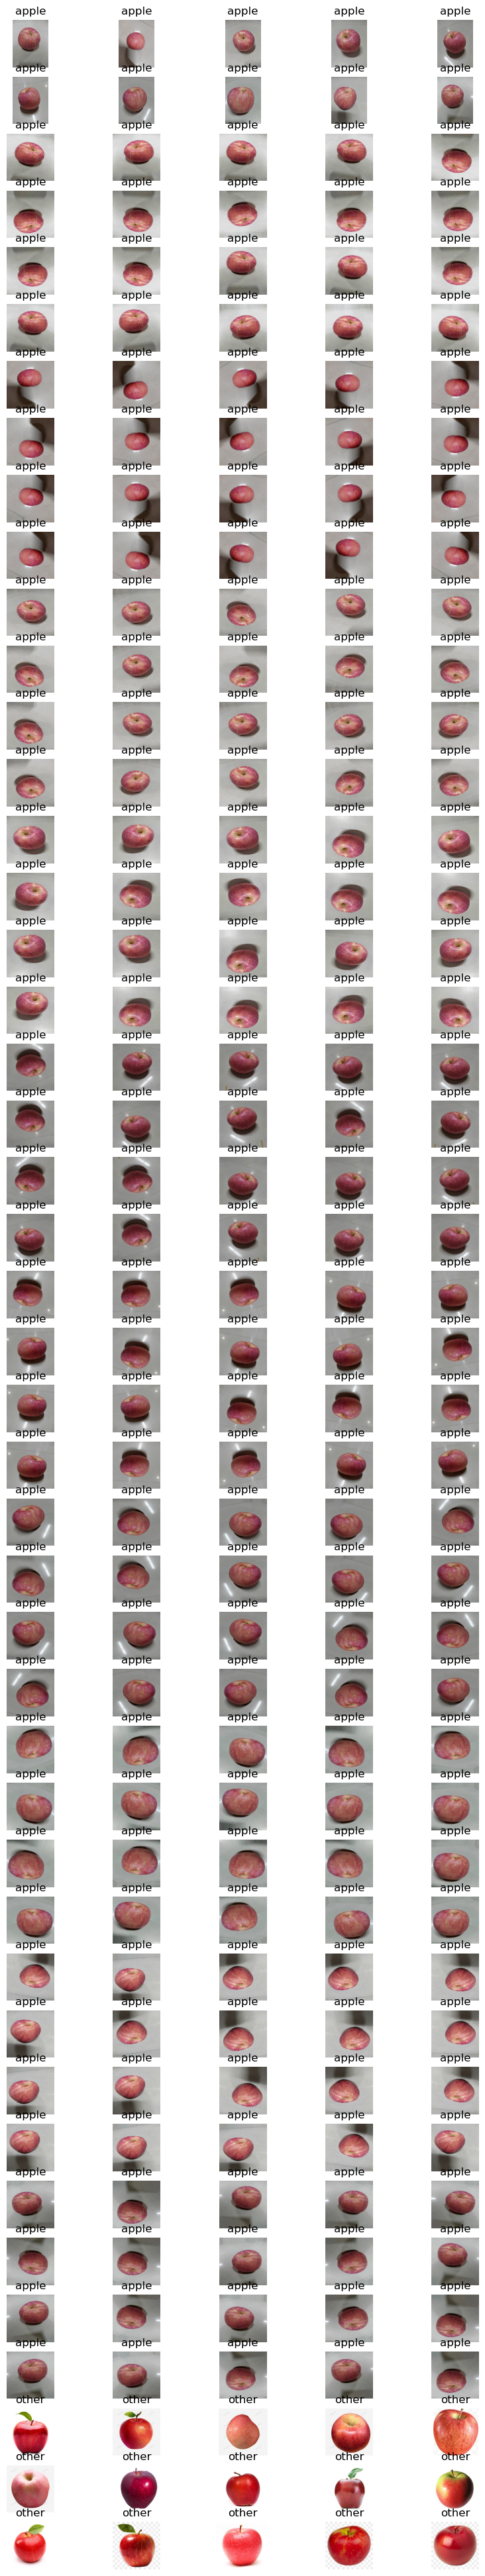

In [65]:
fig4 = plt.figure(figsize=(10,50))
for i in range(45):
    for j in range(5):
        img = load_img(img_path[i*5+j])
        plt.subplot(45,5,i*5+j+1)
        plt.title("apple" if y_predict_ms[i*5+j] == normal_apple_id else "other")
        plt.imshow(img)
        plt.axis("off")

In [66]:
#预测 测试集
y_predict_ms_test = cnn_ms.predict(X_test)
print(y_predict_ms_test)

[ 0  0  0  0  0  0 12  9 16 19  4  0]


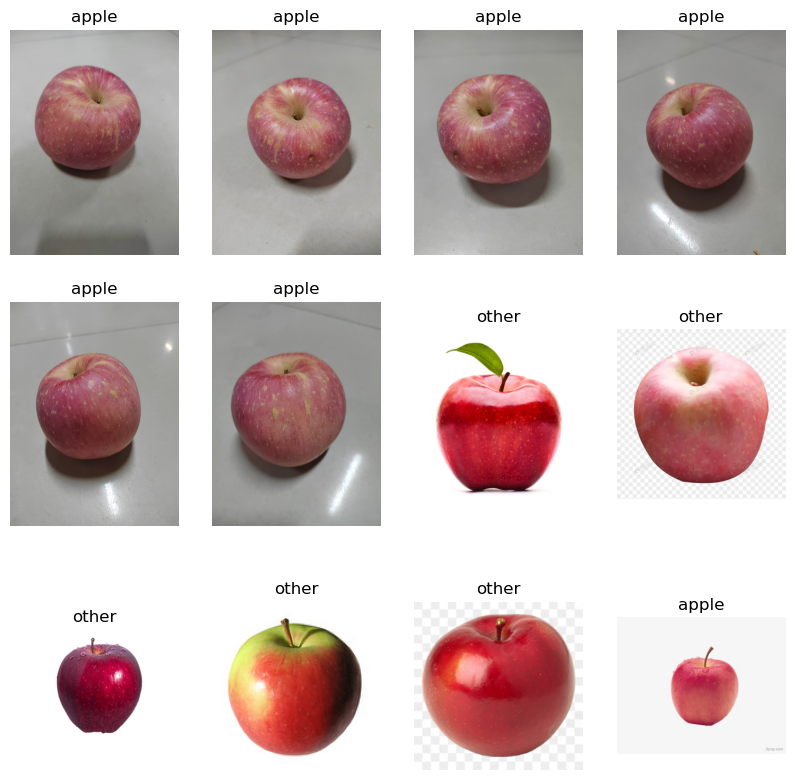

In [68]:
# visualize the resilt
fig5 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(img_path_test[i*4+j])
        plt.subplot(3,4,i*4+j+1)
        plt.title("apple" if y_predict_ms_test[i*4+j] == normal_apple_id else "other")
        plt.imshow(img)
        plt.axis("off")

In [69]:
# PCA 降维
from sklearn.preprocessing import StandardScaler
stds = StandardScaler()
X_norm = stds.fit_transform(X)
# PCA analusis 主成分分析
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_norm)

In [70]:
#calculate the variance ratio of each components
var_ratio = pca.explained_variance_ratio_
print(np.sum(var_ratio))

0.981035028753068


In [71]:
print(X_pca.shape,X.shape)

(230, 200) (230, 25088)


In [72]:
# 再meanshift
from sklearn.cluster import MeanShift,estimate_bandwidth
# obtain the bandwidth
bw = estimate_bandwidth(X_pca,n_samples=140) #用处理后的数据
print(bw)
# set up meanshift model
cnn_pca_ms = MeanShift(bandwidth=bw)
cnn_pca_ms.fit(X_pca)

171.73061200283544


MeanShift(bandwidth=171.73061200283544)

In [73]:
# make prediction
y_predict_pca_ms = cnn_pca_ms.predict(X_pca)
print(y_predict_pca_ms)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 17  0  0  0  0 21 19  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0
 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 24  0  0 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  9  0 10  1 14
 16  0 13 12  0  2 15  3  5  8  4  6 11  0]


In [74]:
# 统计预测结果
print(Counter(y_predict_pca_ms))

Counter({0: 206, 17: 1, 21: 1, 19: 1, 22: 1, 18: 1, 24: 1, 23: 1, 20: 1, 7: 1, 9: 1, 10: 1, 1: 1, 14: 1, 16: 1, 13: 1, 12: 1, 2: 1, 15: 1, 3: 1, 5: 1, 8: 1, 4: 1, 6: 1, 11: 1})


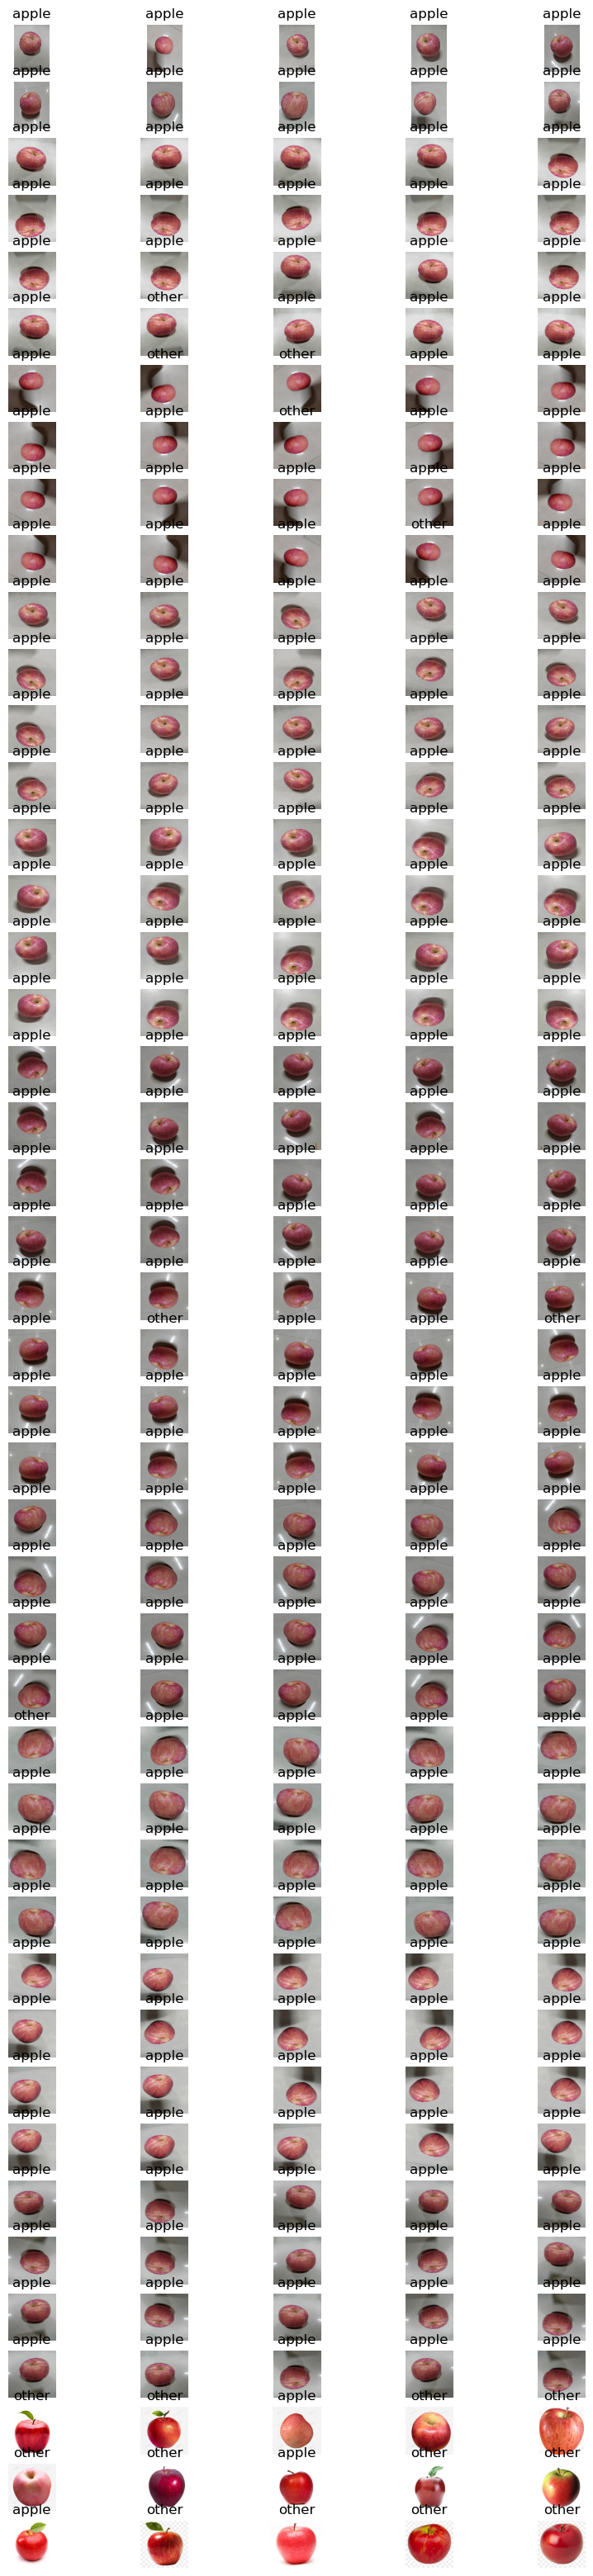

In [75]:
fig6 = plt.figure(figsize=(10,40))
for i in range(45):
    for j in range(5):
        img = load_img(img_path[i*5+j])
        plt.subplot(45,5,i*5+j+1)
        plt.title("apple" if y_predict_pca_ms[i*5+j] == normal_apple_id else "other")
        plt.imshow(img)
        plt.axis("off")

In [76]:
#数据转换
X_norm_test = stds.transform(X_test)
X_pca_test = pca.transform(X_norm_test)

In [77]:
#预测 测试集
y_predict_pca_ms_test = cnn_pca_ms.predict(X_pca_test)
print(y_predict_pca_ms_test)
# 统计预测结果
print(Counter(y_predict_pca_ms_test))

[ 0  0  0  0  0  0  7 14 16 12  5  0]
Counter({0: 7, 7: 1, 14: 1, 16: 1, 12: 1, 5: 1})


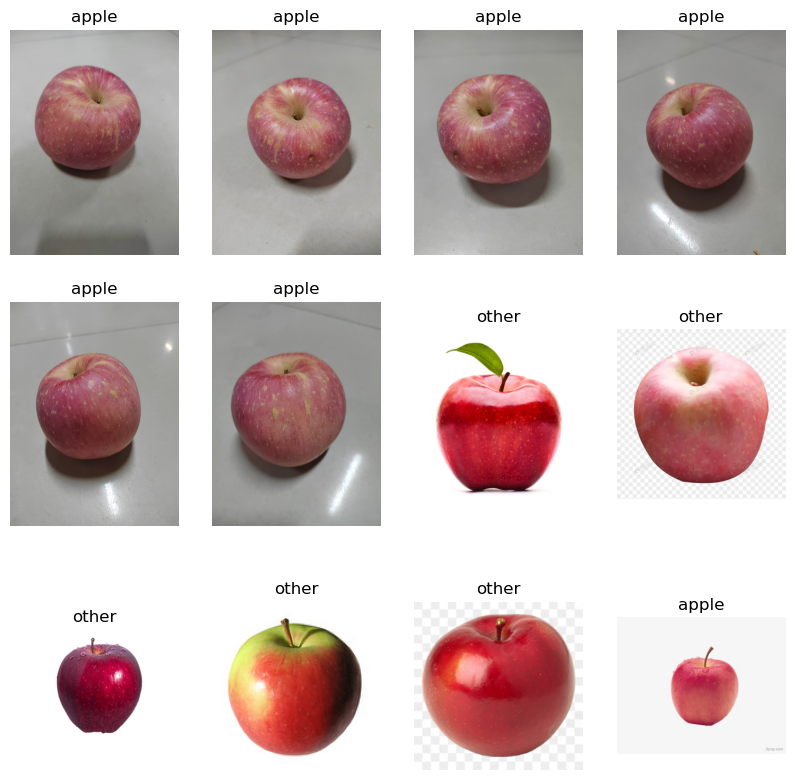

In [78]:
# visualize the resilt
fig7 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(img_path_test[i*4+j])
        plt.subplot(3,4,i*4+j+1)
        plt.title("apple" if y_predict_pca_ms_test[i*4+j] == normal_apple_id else "other")
        plt.imshow(img)
        plt.axis("off")

**普通/其他苹果检测实战summary**
1.通过搭建混合模型，实现监督+无监督、机器+深度学习技术的有机结合，并在少样本的情况下建立起了有效区分普通/其他苹果的模型
2.针对少样本任务，掌握生成新数据的数据增强方法；
3.更熟练的掌握了拆分经典VGG16模型并用于提取图象特征的方法；
4.完成了图象的批量处理；
5.回顾了无监督聚类算法：KMeans、Meanshift，并通过标签数据分布实现数据类别矫正；
6.成功引入PCA数据降维技术，剔除数据中的噪音信息、降低模型复杂度、减少模型训练时间，最终提高模型表现；
7.考虑一些其他方法去完成任务，比如异常数据检测技术；